# Partial Differential Equations 

In [1]:
%pylab inline
import tensorflow as tf
import numpy as np
import PIL.Image

from io import  BytesIO
from IPython.display import clear_output, Image, display

Populating the interactive namespace from numpy and matplotlib


### Array to Image

pond's surface의 상태를 이미지로 보여주는 함수

In [2]:
def display_array(a, format='jpeg', rng=[0, 1]):
    """
    display an array as a picture
    """
    a = (a - rng[0])/float(rng[1] - rng[0])*255 # array는 0~1사이의 값을 갖는데, min-max를 통해 0~255사이의 값으로 변환
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, format)
    clear_output(wait=True)
    display(Image(data=f.getvalue()))

### Computational Convenience Functions 

In [3]:
def make_kernel(a):
    """
    Transform a 2D array into a convolutional kernel
    """
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    """ 
    A simplified 2D convolution operation
    """
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

def laplace(x): 
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                             [1.0, -6., 1.0],
                             [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)  


### Create an interactive session

In [4]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

### Configurations

N 값은 pond를 나타내며 500 * 500 정사각형입니다. 

In [5]:
N = 500

### Create a pond!

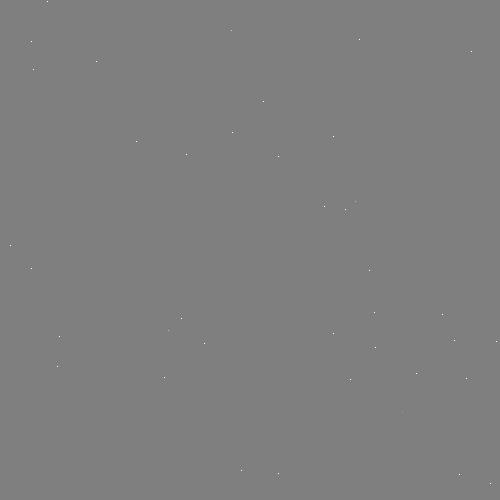

In [6]:
u_init = np.zeros([N, N], dtype='float32')
ut_init = np.zeros([N, N], dtype='float32')

# Some rain drops hit a pond at random points
for n in range(40):
    rain_x, rain_y = np.random.randint(0, N, 2)
    u_init[rain_x, rain_y] = np.random.uniform()

display_array(u_init, rng=[-0.1, 0.1])

### Pond Differential Equation

1. eps -- time resolution<Br>
2. damping -- save damping 

In [11]:
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# simulation state
U = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(U.assign(U_), Ut.assign(Ut_))

### Run the simulation

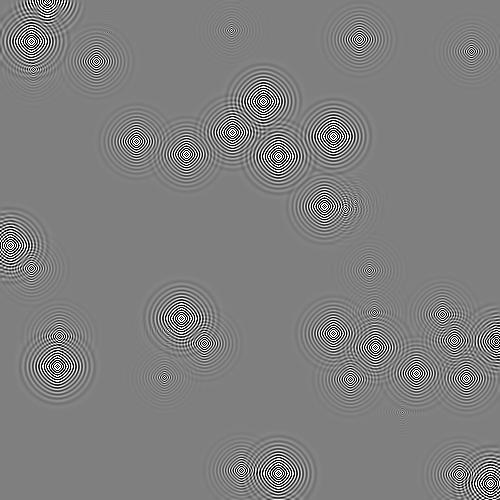

In [24]:
tf.global_variables_initializer().run()

for i in range(1000):
    step.run({eps: 0.03, damping: 0.04})
    display_array(U.eval(), rng=[-0.1, 0.1])